In [1]:
!pip install skorch
!pip install modAL-python
!pip install scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.8/125.8 kB 9.6 MB/s eta 0:00:00
  Attempting uninstall: skorch
    Found existing installation: skorch 1.0.0
    Uninstalling skorch-1.0.0:
      Successfully uninstalled skorch-1.0.0


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [4]:
from sklearn.metrics import f1_score

def eval_prioritization_strategy(prioritizer):
    train_indices = list(range(60000))

    test_accuracies = []
    test_f1_scores = []
    x_train_subset = np.zeros([0, 28, 28])
    y_train_subset = np.empty([0,])

    for i in range(40):
        selected_indices = train_indices[0:500]
        train_indices = train_indices[500:]
        x_train_subset = np.concatenate((x_train_subset, x_train[selected_indices,...]))
        y_train_subset = np.concatenate((y_train_subset, y_train[selected_indices,...]))

        model = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax')
        ])

        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

        model.fit(x_train_subset, y_train_subset, epochs=5, verbose=0)
        loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
        test_accuracies.append(accuracy)

        # Get predictions for F1 score calculation
        y_pred = np.argmax(model.predict(x_test), axis=1)
        f1 = f1_score(y_test, y_pred, average='weighted')
        test_f1_scores.append(f1)

        print(f'Training data size of {x_train_subset.shape[0]} => accuracy {accuracy:.4f}, F1 Score {f1:.4f}')

        # Update train indices based on prioritization strategy
        predictions = model.predict(x_train[train_indices,...])
        train_indices = prioritizer(train_indices, predictions)

    return test_accuracies, test_f1_scores

In [5]:
unprioritized_accuracies, unprioritized_f1 = eval_prioritization_strategy(lambda indices, pred: indices)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training data size of 500 => accuracy 0.8250, F1 Score 0.8243
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training data size of 1000 => accuracy 0.8729, F1 Score 0.8721
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 1500 => accuracy 0.8846, F1 Score 0.8850
1829/1829 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 2000 => accuracy 0.9001, F1 Score 0.9000
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 2500 => accuracy 0.8975, F1 Score 0.8979
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 3000 => accuracy 0.9086, F1 Score 0.9082
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training data size of 3500 => accuracy 0.9143, F1 Score 0.9142
1766/1766 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Training data size of 4000 => accuracy 0.9213, F1 Score 0.9215
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 4500 => accuracy 0.9274, F1 Score 0.9272
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Training data size of 5000 => accuracy 0.9319, F1 Score 0.9319
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 5500 => accuracy 0.9278, F1 Score 0.9277
1704/1704 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training data size of 6000 => accuracy 0.9284, F1 Score 0.9285
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 6500 => accuracy 0.9276, F1 Score 0.9275
1672/1672 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training data size of 7000 => accuracy 0.9372, F1 Score 0.9371
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 7500 => accuracy 0.9360, F1 Score 0.9359
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 8000 => accuracy 0.9410, F1 Score 0.9409
1625/1625 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 8500 => accuracy 0.9378, F1 Score 0.9379
1610/1610 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 9000 => accuracy 0.9402, F1 Score 0.9403
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 9500 => accuracy 0.9420, F1 Score 0.9421
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 10000 => accuracy 0.9419, F1 Score 0.9417
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 10500 => accuracy 0.9459, F1 Score 0.9459
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 11000 => accuracy 0.9467, F1 Score 0.9465
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 11500 => accuracy 0.9461, F1 Score 0.9461
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training data size of 12000 => accuracy 0.9508, F1 Score 0.9508
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 12500 => accuracy 0.9513, F1 Score 0.9513
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 13000 => accuracy 0.9559, F1 Score 0.9559
1469/1469 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 13500 => accuracy 0.9546, F1 Score 0.9546
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training data size of 14000 => accuracy 0.9538, F1 Score 0.9538
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training data size of 14500 => accuracy 0.9567, F1 Score 0.9566
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training data size of 15000 => accuracy 0.9570, F1 Score 0.9570
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training data size of 15500 => accuracy 0.9547, F1 Score 0.9547
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training data size of 16000 => accuracy 0.9606, F1 Score 0.9605
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training data size of 16500 => accuracy 0.9587, F1 Score 0.9587
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training data size of 17000 => accuracy 0.9544, F1 Score 0.9544
1344/1344 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 17500 => accuracy 0.9584, F1 Score 0.9582
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 18000 => accuracy 0.9554, F1 Score 0.9555
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 18500 => accuracy 0.9604, F1 Score 0.9604
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 19000 => accuracy 0.9608, F1 Score 0.9608
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 19500 => accuracy 0.9619, F1 Score 0.9619
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 20000 => accuracy 0.9613, F1 Score 0.9613
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [6]:
def least_confidence_prediction_prioritizer(indices, predictions):
  max_logit = list(zip(indices, np.amax(predictions,axis=1)))
  max_logit.sort(key=lambda x: x[1]) # sort in ascending order
  return list(zip(*max_logit))[0]

In [7]:
least_confidence_accuracies, least_confidence_f1 = eval_prioritization_strategy(least_confidence_prediction_prioritizer)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training data size of 500 => accuracy 0.8244, F1 Score 0.8227
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 1000 => accuracy 0.8608, F1 Score 0.8619
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 1500 => accuracy 0.8833, F1 Score 0.8840
1829/1829 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training data size of 2000 => accuracy 0.9131, F1 Score 0.9133
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 2500 => accuracy 0.9215, F1 Score 0.9212
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 3000 => accuracy 0.9379, F1 Score 0.9381
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 3500 => accuracy 0.9439, F1 Score 0.9439
1766/1766 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 4000 => accuracy 0.9456, F1 Score 0.9457
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 4500 => accuracy 0.9525, F1 Score 0.9525
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 5000 => accuracy 0.9562, F1 Score 0.9562
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 5500 => accuracy 0.9607, F1 Score 0.9607
1704/1704 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 6000 => accuracy 0.9659, F1 Score 0.9659
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 6500 => accuracy 0.9658, F1 Score 0.9658
1672/1672 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 7000 => accuracy 0.9709, F1 Score 0.9709
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 7500 => accuracy 0.9694, F1 Score 0.9694
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 8000 => accuracy 0.9692, F1 Score 0.9692
1625/1625 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training data size of 8500 => accuracy 0.9705, F1 Score 0.9705
1610/1610 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 9000 => accuracy 0.9734, F1 Score 0.9734
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training data size of 9500 => accuracy 0.9709, F1 Score 0.9709
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training data size of 10000 => accuracy 0.9696, F1 Score 0.9695
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 10500 => accuracy 0.9727, F1 Score 0.9727
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 11000 => accuracy 0.9750, F1 Score 0.9750
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 11500 => accuracy 0.9732, F1 Score 0.9732
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 12000 => accuracy 0.9773, F1 Score 0.9773
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 12500 => accuracy 0.9764, F1 Score 0.9764
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 13000 => accuracy 0.9729, F1 Score 0.9728
1469/1469 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 13500 => accuracy 0.9740, F1 Score 0.9740
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 14000 => accuracy 0.9763, F1 Score 0.9763
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 14500 => accuracy 0.9749, F1 Score 0.9749
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 15000 => accuracy 0.9734, F1 Score 0.9734
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training data size of 15500 => accuracy 0.9749, F1 Score 0.9749
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 16000 => accuracy 0.9756, F1 Score 0.9756
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 16500 => accuracy 0.9749, F1 Score 0.9749
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 17000 => accuracy 0.9742, F1 Score 0.9742
1344/1344 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 17500 => accuracy 0.9736, F1 Score 0.9736
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 18000 => accuracy 0.9753, F1 Score 0.9753
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 18500 => accuracy 0.9748, F1 Score 0.9748
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 19000 => accuracy 0.9772, F1 Score 0.9772
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 19500 => accuracy 0.9771, F1 Score 0.9771
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 20000 => accuracy 0.9737, F1 Score 0.9737
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [8]:
def entropy_prioritizer(indices, predictions):
  p = predictions * np.log(predictions)
  p = -p.sum(axis=1)
  p = list(zip(indices, p))
  p.sort(reverse=True, key=lambda x : x[1]) # sort in descending order
  return list(zip(*p))[0]

In [9]:
entropy_prioritized_accuracies, entropy_prioritized_f1 = eval_prioritization_strategy(entropy_prioritizer)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 500 => accuracy 0.8314, F1 Score 0.8302
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 1000 => accuracy 0.8530, F1 Score 0.8535
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 1500 => accuracy 0.8758, F1 Score 0.8769
1829/1829 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training data size of 2000 => accuracy 0.8939, F1 Score 0.8946
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 2500 => accuracy 0.9208, F1 Score 0.9209
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 3000 => accuracy 0.9243, F1 Score 0.9246
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 3500 => accuracy 0.9396, F1 Score 0.9396
1766/1766 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 4000 => accuracy 0.9427, F1 Score 0.9427
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 4500 => accuracy 0.9498, F1 Score 0.9499
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 5000 => accuracy 0.9504, F1 Score 0.9505
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 5500 => accuracy 0.9580, F1 Score 0.9581
1704/1704 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 6000 => accuracy 0.9565, F1 Score 0.9566
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 6500 => accuracy 0.9663, F1 Score 0.9663
1672/1672 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 7000 => accuracy 0.9645, F1 Score 0.9645
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training data size of 7500 => accuracy 0.9665, F1 Score 0.9665
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 8000 => accuracy 0.9694, F1 Score 0.9694
1625/1625 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 8500 => accuracy 0.9683, F1 Score 0.9683
1610/1610 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 9000 => accuracy 0.9708, F1 Score 0.9708
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 9500 => accuracy 0.9697, F1 Score 0.9697
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training data size of 10000 => accuracy 0.9721, F1 Score 0.9721
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 10500 => accuracy 0.9719, F1 Score 0.9719
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 11000 => accuracy 0.9745, F1 Score 0.9745
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 11500 => accuracy 0.9739, F1 Score 0.9739
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 12000 => accuracy 0.9735, F1 Score 0.9735
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 12500 => accuracy 0.9733, F1 Score 0.9733
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 13000 => accuracy 0.9742, F1 Score 0.9742
1469/1469 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 13500 => accuracy 0.9754, F1 Score 0.9754
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 14000 => accuracy 0.9757, F1 Score 0.9757
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 14500 => accuracy 0.9742, F1 Score 0.9742
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 15000 => accuracy 0.9734, F1 Score 0.9734
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 15500 => accuracy 0.9760, F1 Score 0.9760
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 16000 => accuracy 0.9762, F1 Score 0.9762
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 16500 => accuracy 0.9740, F1 Score 0.9739
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training data size of 17000 => accuracy 0.9749, F1 Score 0.9749
1344/1344 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 17500 => accuracy 0.9762, F1 Score 0.9762
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 18000 => accuracy 0.9760, F1 Score 0.9760
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 18500 => accuracy 0.9764, F1 Score 0.9764
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 19000 => accuracy 0.9746, F1 Score 0.9746
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 19500 => accuracy 0.9745, F1 Score 0.9745
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 20000 => accuracy 0.9737, F1 Score 0.9737
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [10]:
def margin_prioritizer(indices, predictions):
  p = -np.sort(-predictions) # sort in descending order
  p = p[:,0] - p[:,1]
  p = list(zip(indices, p))
  p.sort(key=lambda x : x[1]) # sort in ascending order
  return list(zip(*p))[0]

In [11]:
margin_prioritized_accuracies, margin_prioritized_f1  = eval_prioritization_strategy(margin_prioritizer)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 500 => accuracy 0.8193, F1 Score 0.8184
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 1000 => accuracy 0.8968, F1 Score 0.8965
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 1500 => accuracy 0.9162, F1 Score 0.9162
1829/1829 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 2000 => accuracy 0.9256, F1 Score 0.9254
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training data size of 2500 => accuracy 0.9401, F1 Score 0.9401
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 3000 => accuracy 0.9452, F1 Score 0.9451
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 3500 => accuracy 0.9495, F1 Score 0.9494
1766/1766 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training data size of 4000 => accuracy 0.9539, F1 Score 0.9541
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training data size of 4500 => accuracy 0.9576, F1 Score 0.9575
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 5000 => accuracy 0.9640, F1 Score 0.9640
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 5500 => accuracy 0.9628, F1 Score 0.9627
1704/1704 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 6000 => accuracy 0.9660, F1 Score 0.9660
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 6500 => accuracy 0.9699, F1 Score 0.9699
1672/1672 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training data size of 7000 => accuracy 0.9704, F1 Score 0.9704
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 7500 => accuracy 0.9708, F1 Score 0.9708
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 8000 => accuracy 0.9721, F1 Score 0.9721
1625/1625 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 8500 => accuracy 0.9732, F1 Score 0.9732
1610/1610 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 9000 => accuracy 0.9736, F1 Score 0.9736
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 9500 => accuracy 0.9748, F1 Score 0.9748
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 10000 => accuracy 0.9729, F1 Score 0.9729
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training data size of 10500 => accuracy 0.9735, F1 Score 0.9735
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training data size of 11000 => accuracy 0.9731, F1 Score 0.9731
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training data size of 11500 => accuracy 0.9734, F1 Score 0.9734
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Training data size of 12000 => accuracy 0.9751, F1 Score 0.9751
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 12500 => accuracy 0.9745, F1 Score 0.9745
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 13000 => accuracy 0.9739, F1 Score 0.9739
1469/1469 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 13500 => accuracy 0.9758, F1 Score 0.9758
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 14000 => accuracy 0.9735, F1 Score 0.9735
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 14500 => accuracy 0.9751, F1 Score 0.9751
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 15000 => accuracy 0.9764, F1 Score 0.9764
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 15500 => accuracy 0.9773, F1 Score 0.9773
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 16000 => accuracy 0.9709, F1 Score 0.9709
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training data size of 16500 => accuracy 0.9750, F1 Score 0.9750
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training data size of 17000 => accuracy 0.9763, F1 Score 0.9763
1344/1344 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training data size of 17500 => accuracy 0.9728, F1 Score 0.9729
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training data size of 18000 => accuracy 0.9754, F1 Score 0.9754
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 18500 => accuracy 0.9748, F1 Score 0.9748
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training data size of 19000 => accuracy 0.9762, F1 Score 0.9762
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training data size of 19500 => accuracy 0.9745, F1 Score 0.9745
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training data size of 20000 => accuracy 0.9729, F1 Score 0.9729
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


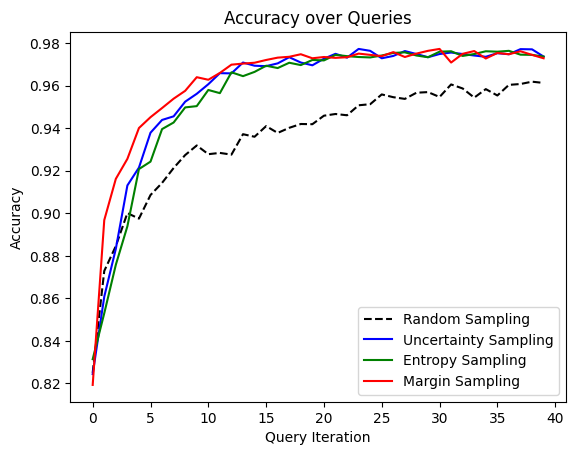

In [16]:
plt.plot(unprioritized_accuracies, 'k', label='Random Sampling', linestyle='--')
plt.plot(least_confidence_accuracies, 'b', label='Uncertainty Sampling')
plt.plot(entropy_prioritized_accuracies, 'g', label='Entropy Sampling')
plt.plot(margin_prioritized_accuracies, 'r', label='Margin Sampling')
plt.title("Accuracy over Queries")
plt.xlabel("Query Iteration")
plt.ylabel("Accuracy")
plt.legend()

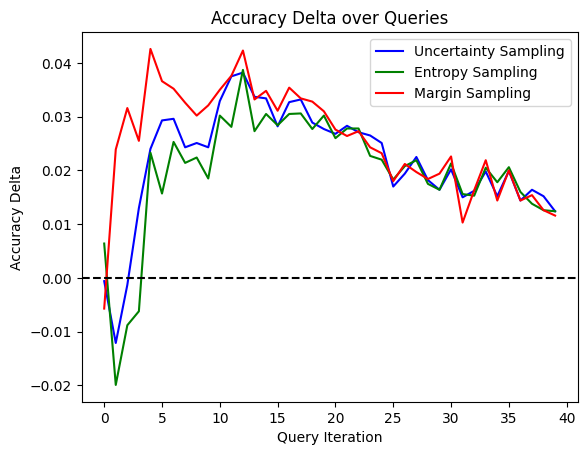

In [18]:
plt.plot(np.array(least_confidence_accuracies) - np.array(unprioritized_accuracies), 'b', label='Uncertainty Sampling')
plt.plot(np.array(entropy_prioritized_accuracies) - np.array(unprioritized_accuracies), 'g', label='Entropy Sampling')
plt.plot(np.array(margin_prioritized_accuracies) - np.array(unprioritized_accuracies), 'r', label='Margin Sampling')
plt.title("Accuracy Delta over Queries")
plt.xlabel("Query Iteration")
plt.ylabel("Accuracy Delta")
plt.axhline(y=0, color='black', linestyle='--')
plt.grid(False)
plt.legend()

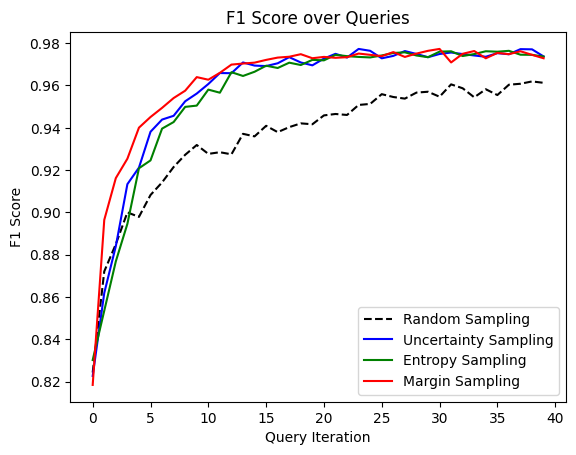

In [19]:
plt.plot(unprioritized_f1, 'k', label='Random Sampling', linestyle='--')
plt.plot(least_confidence_f1, 'b', label='Uncertainty Sampling')
plt.plot(entropy_prioritized_f1, 'g', label='Entropy Sampling')
plt.plot(margin_prioritized_f1, 'r', label='Margin Sampling')
plt.title("F1 Score over Queries")
plt.xlabel("Query Iteration")
plt.ylabel("F1 Score")
plt.legend()

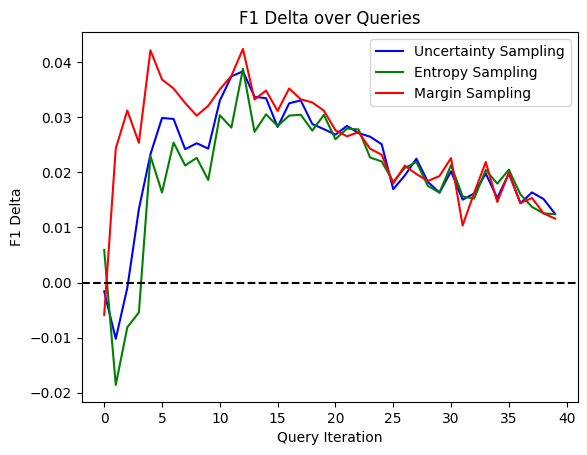

In [20]:
plt.plot(np.array(least_confidence_f1) - np.array(unprioritized_f1), 'b', label='Uncertainty Sampling')
plt.plot(np.array(entropy_prioritized_f1) - np.array(unprioritized_f1), 'g', label='Entropy Sampling')
plt.plot(np.array(margin_prioritized_f1) - np.array(unprioritized_f1), 'r', label='Margin Sampling')
plt.title("F1 Delta over Queries")
plt.xlabel("Query Iteration")
plt.ylabel("F1 Delta")
plt.axhline(y=0, color='black', linestyle='--')
plt.grid(False)
plt.legend()